<a id="content"></a>
# QF605 Project: Fixed Income Securities
## `Part II`: Swaption Calibration
### Team Members:
>Anirban CHAKRABORTY<br>
Boon Heng GOH<br>
Hanley Mahesh RUPAWALLA<br>
Kantapong ARUNADITYA<br>
Maria Vinitha VIJAYANAND<br>
Retwika HAZRA

- [Question 1](#Question1) <= Click
- [Question 2](#Question2)
- [Question 3](#Question3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import brentq, least_squares, curve_fit
from scipy.stats import norm
from scipy.integrate import quad
from math import log, exp, sqrt
from scipy import interpolate
from scipy.interpolate import CubicSpline

`Importing results from part I (Bootstrapping Swap Curves)`

In [2]:
df_comb = pd.read_csv('Rates_Raw.csv')
df_ForwardSwap = pd.read_csv('Swap_Rates_Raw.csv')

Under the Swaption tab of IR Data.xlsm, swaption implied volatilities (lognormal) are provided.

In [3]:
# Importing IR Data (Swaption)

df_vol = pd.read_excel('IR Data.xlsx', 'Swaption', skiprows=[0,1])
df_vol.reset_index(drop=True, inplace = True)
df_vol.iloc[:, 2:] = np.float64(df_vol.iloc[:, 2:]/100)
df_Strikes = df_vol.copy(deep=True)

`Adding Forward Swap Rate into IR Data (Swaption)`

In [4]:
df_vol['FSR'] = df_ForwardSwap['Swap_Rate']
df_vol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,FSR
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297,0.032007
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,0.033259
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833,0.034011
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,0.034261
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,0.035255
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980,0.038427
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760,0.039273
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150,0.040074
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400,0.040070
9,5Y,10Y,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250,0.040484


`Creating dataframe for strikes`

In [5]:
swaption = pd.read_excel (r'IR Data.xlsx', sheet_name='Swaption', skiprows = 2, header = 0)
swaption = swaption.iloc[0:15,0:13]
swaption.iloc[:, 2:] = swaption.iloc[:, 2:] / 100
df_Strikes = swaption.copy(deep=True)
bps = [0 if i == 7 else float(swaption.columns[i][0:-3]) / 10000
       for i in range(2, len(swaption.columns))]
for i in range(len(swaption.columns[2:])):
    df_Strikes.loc[:, swaption.columns[2 + i]] = df_ForwardSwap.iloc[:, 2] + bps[i] 
#df_Strikes

<a id="Question1"></a>
### 1. Calibrate `displaced-diffusion` model to the swaption market data, and document.

- a table of $\sigma$ parameters
- a table of $\beta$ parameters

`PVBP` $= P_{n+1,N}(0)$

$$V^{payer}_{n,N}(0) = P_{n+1,N}(0)E^{n+1,N}[(S_{n,N}(T)-K)^+]$$
$$V^{receiver}_{n,N}(0) = P_{n+1,N}(0)E^{n+1,N}[(K-S_{n,N}(T))^+]$$

In [6]:
def OISDifInterp(tenor):
    xp = list(df_comb['Tenor'])
    yp = list(df_comb['ON_DF'])
    return np.interp(tenor, xp, yp)

def PVBP(expiry,tenor):
    m = int(tenor/0.5)
    summa = 0
    for i in range(1,m+1):
        summa += OISDifInterp(expiry + i*0.5)
    return summa*0.5

`Black76 Model - Payer`

$$V_{n,N}^{payer}(0) = P_{n+1,N}(0)[S_{n,N}(0)\Phi(d_{1})-K\Phi(d_{2})]$$

`Black76 Model - Receiver`

$$V_{n,N}^{receiver}(0) = P_{n+1,N}(0)[K\Phi(-d_{2})-S_{n,N}(0)\Phi(-d_{1})]$$

where,

$$d_{1}=\frac{log\frac{S_{n,N}(0)}{K}+\frac{1}{2}\sigma_{n,N}^{2}T}{\sigma_{n,N}\sqrt{T}},\ d_{2}=d_{1} - \sigma_{n,N}\sqrt{T}$$

In [7]:
def Black76Lognormal(F,K,T,sigma, opt):
    d1 = (log(F/K)+(sigma*sigma/2)*T[0])/(sigma*sqrt(T[0]))
    d2 = d1-sigma*sqrt(T[0])
    D=PVBP(T[0],T[1]) #Discount Factor is replaced by PVBP
    
    if opt == 'Call':# payer 
        return F*D*norm.cdf(d1) - K*D*norm.cdf(d2)
    elif opt == 'Put': # receiver
        return K*D*norm.cdf(-d2) - F*D*norm.cdf(-d1)
    
def Black76ImpVol(F, K, T, price, opt):
    impliedVol = brentq(lambda x: price - Black76Lognormal(F, K, T, x, opt), 1e-6, 1)  # x is sigma
    return impliedVol

def ImpliedVols(F, K, T,price, opt):
    lst = []
    for i in range(len(price)):
        lst.append(Black76ImpVol(F, K[i], T, price[i], opt))
    return lst

`Displaced Diffusion`

$$V_{n,N}(0) = P_{n+1,N}(0)Black76\left(\frac{S_{n,N}(0)}{\beta},\ K+\frac{1-\beta}{\beta}S_{n,N}(0),\ \sigma\beta, \ T\right)$$

In [8]:
def Displaced_Diffusion(F, K, T, sigma, beta, opt):
    return Black76Lognormal(F/beta, K+(1-beta)/beta*F, T,sigma*beta, opt)

def DisDifImv(F, K1, K2, T,sigma, beta):    
    P, C = [], [] #P is price of Put Option, C is price of Call option
    for k1 in K1: # K1 put strikes
        P.append(Displaced_Diffusion(F, k1, T, sigma, beta, 'Put')) # price is calculated using DD Model
    for k2 in K2: # K2 call strikes
        C.append(Displaced_Diffusion(F, k2, T,sigma, beta, 'Call')) 
    P_imv = ImpliedVols(F, K1, T, P, 'Put')  # implied vol is calculated using Black 76
    C_imv = ImpliedVols(F, K2, T, C, 'Call')
    return P_imv + C_imv

def DisDif_Optmize(F, K1, K2, T, x, MarImpVol):
    P, C = [], []
    for k1 in K1:
        P.append(Displaced_Diffusion(F, k1, T, df_vol.iloc[i,7], x,'Put'))   # price is calculated using DD Model
    for k2 in K2:
        C.append(Displaced_Diffusion(F, k2, T, df_vol.iloc[i,7], x,'Call'))
    P_imv = ImpliedVols(F, K1, T, P, 'Put')    # implied vol is calculated using Black 76
    C_imv = ImpliedVols(F, K2, T, C, 'Call')
    error = np.array(P_imv + C_imv) - np.array(MarImpVol)   # error implied vol vs market vol
    return np.dot(error, error)

In [9]:
ExpTenor = ['1x1','1x2', '1x3','1x5','1x10',
            '5x1','5x2', '5x3','5x5','5x10',
            '10x1','10x2', '10x3','10x5','10x10']
T = [[1,1],[1,2],[1,3],[1,5],[1,10],[5,1],[5,2],[5,3],[5,5],[5,10],[10,1],[10,2],[10,3],[10,5],[10,10]]

In [10]:
# Use Least Square to search for optimal Beta for different forward swap terms
df_DDImpVol = pd.DataFrame()
for i in df_vol.index:
    F = df_vol['FSR'][i]
    K = df_Strikes.loc[i, '-200bps':'+200bps'].values
        
    K1 = np.array(K)[K<F]
    K2 = np.array(K)[K>=F]

    MarketImpVol = df_vol.loc[i, '-200bps':'+200bps'].values

    w = least_squares(lambda x:DisDif_Optmize(F, K1, K2, T[i], x, MarketImpVol),  # (F, K1put, K2call, T, xprice, MarImpVol)  return error
                      0.1,
                      bounds=([1e-6,1]))  
    
    df_vol.loc[i,'β'] = w.x[0]
    df_DDImpVol[ExpTenor[i]+' DisDifImv'] = DisDifImv(F,K1,K2,T[i],
              df_vol.iloc[i,7],df_vol.loc[i,'β'])
    print('Optimal [β]for Displaced-diffusion:', [df_vol.loc[i,'β']])

Optimal [β]for Displaced-diffusion: [1.0000058724704098e-06]
Optimal [β]for Displaced-diffusion: [1.0001587118987198e-06]
Optimal [β]for Displaced-diffusion: [1.000922081446195e-06]
Optimal [β]for Displaced-diffusion: [1.0044532878389784e-06]
Optimal [β]for Displaced-diffusion: [6.18740883127477e-06]
Optimal [β]for Displaced-diffusion: [1.0014849812389447e-06]
Optimal [β]for Displaced-diffusion: [1.1486100255289752e-06]
Optimal [β]for Displaced-diffusion: [2.0901185220007553e-06]
Optimal [β]for Displaced-diffusion: [2.607539444380528e-05]
Optimal [β]for Displaced-diffusion: [0.1373034264802888]
Optimal [β]for Displaced-diffusion: [1.2868426617194018e-06]
Optimal [β]for Displaced-diffusion: [2.9760539074323578e-06]
Optimal [β]for Displaced-diffusion: [3.336774593541312e-05]
Optimal [β]for Displaced-diffusion: [0.00025831484633738726]
Optimal [β]for Displaced-diffusion: [0.1]


`Generating ATM Volatility for Displaced Diffusion`

In [11]:
df_sigma = pd.DataFrame(data = np.array(df_vol.ATM).reshape(3,5),
                        index = [1, 5, 10],
                        columns = [1, 2, 3, 5, 10])
df_sigma

,1,2,3,5,10
1,0.2250,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.2660,0.2451
10,0.2854,0.2928,0.2940,0.2674,0.2437


`Generating Beta for Displaced Diffusion`

In [12]:
df_beta  = pd.DataFrame(data = np.array(df_vol['β']).reshape(3,5),
                        index = [1, 5, 10],
                        columns = [1, 2, 3, 5, 10])
df_beta

,1,2,3,5,10
1,0.000001,0.000001,0.000001,0.000001,0.000006
5,0.000001,0.000001,0.000002,0.000026,0.137303
10,0.000001,0.000003,0.000033,0.000258,0.100000


`Plotting Displaced diffusion model vs Market vol`

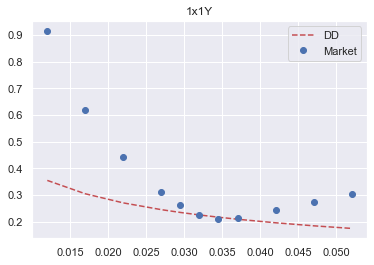

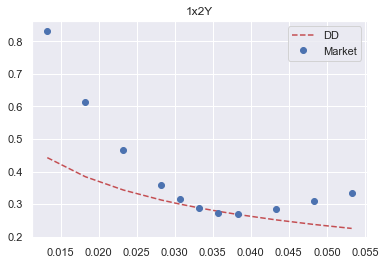

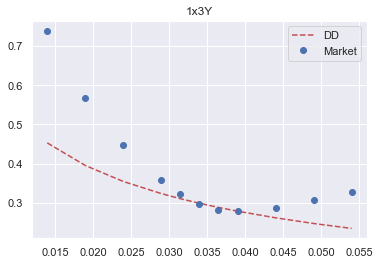

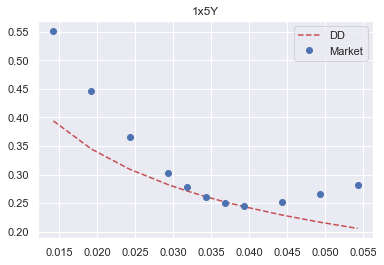

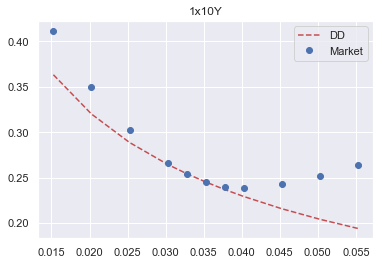

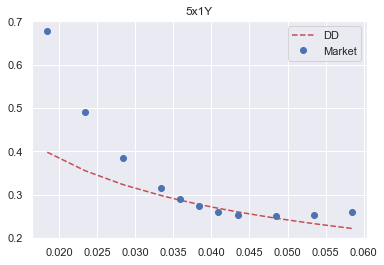

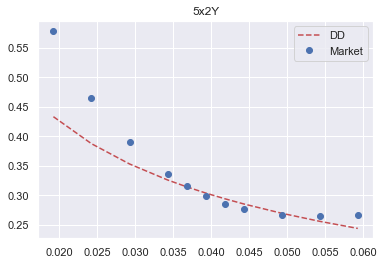

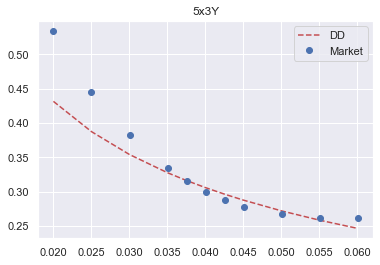

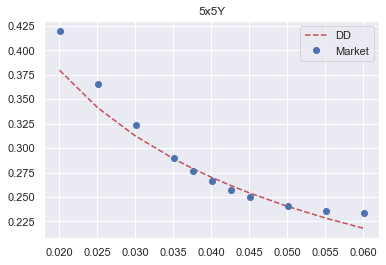

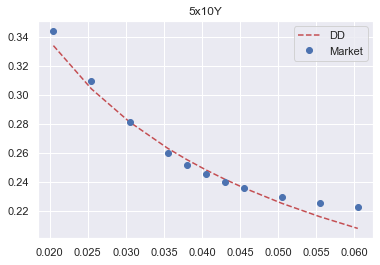

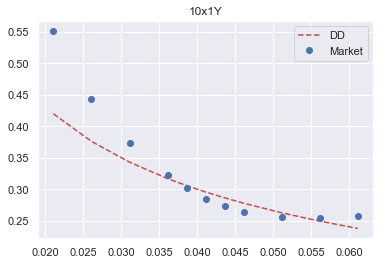

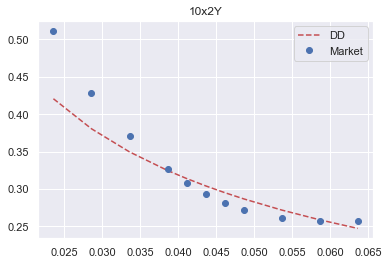

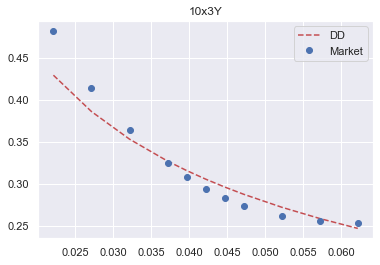

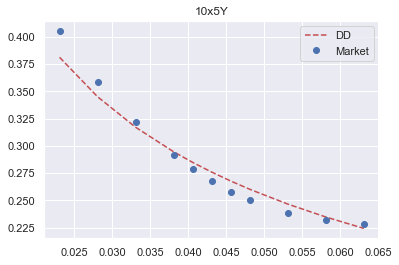

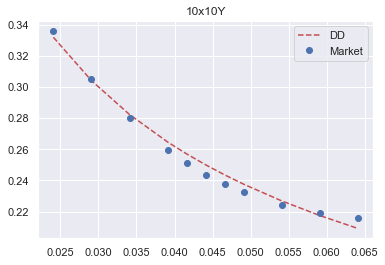

In [13]:
for i in df_Strikes.index:
    sns.set()
    plt.plot(df_Strikes.iloc[i, 2:],df_DDImpVol[ExpTenor[i]+' DisDifImv'],'r--', label="DD")
    plt.plot(df_Strikes.iloc[i, 2:],df_vol.loc[i, '-200bps':'+200bps'],'bo', label="Market")
    plt.legend()
    plt.title(ExpTenor[i]+"Y")
    plt.show() 

[Back to top](#content)

<a id="Question2"></a>
### 2. Calibrate `SABR` model to the swaption market data using $\beta$ = 0.9, and document.

- a table of $\sigma$ parameters
- a table of $\rho$ parameters
- a table of $\nu$ parameters

`SABR Model`

  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{SABR}}(F_0, K, \alpha, \beta, \rho, \nu) = \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}<br>

  where,
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),\  x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right]
    \end{split}
  \end{equation*}

In [14]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    if F == K:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T[0])/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T[0])*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

`SABR Calibration`

In [15]:
def sabrcalibration(F, K, T, x, vols, beta):
    err = 0.0
    for i,vol in enumerate(vols):
        sabr_sol = SABR(F, K[i],T,x[0],beta,x[1],x[2])
        err +=(vol - sabr_sol)**2
    return err

In [16]:
df_SABR = pd.read_excel('IR Data.xlsx', 'Swaption', skiprows=[0,1])
df_SABR.reset_index(drop=True, inplace = True)
df_SABR.iloc[:, 2:] = np.float64(df_SABR.iloc[:, 2:]/100)
df_SABR['FSR'] = df_ForwardSwap['Swap_Rate']
#df_SABR

`Variable and Initial Guess Value`

In [17]:
SABRbeta = 0.9
initial_guess = [0.2, -0.5, 1.5]

In [18]:
for i in df_SABR.index:
    res = least_squares(lambda x: sabrcalibration(df_SABR.loc[i, 'FSR'],
                                                  df_Strikes.iloc[i, 2:],
                                                  T[i],
                                                  x,
                                                  df_SABR.iloc[i, 2:13],
                                                  SABRbeta),
                                                  initial_guess,max_nfev=2000)
    #print(res)
    print(ExpTenor[i],' :',res.x[0],res.x[1],res.x[2] )
    df_SABR.loc[i, 'alpha'] = res.x[0]
    df_SABR.loc[i, 'rho'] = res.x[1]
    df_SABR.loc[i, 'nu'] = res.x[2]
    initial_guess = [res.x[0],res.x[1],res.x[2]]

1x1  : 0.13907352293104924 -0.6332227130273759 2.049416015636752
1x2  : 0.18463167260522895 -0.5251281947012663 1.6775751588197036
1x3  : 0.19683784629186638 -0.4828279586434631 1.4382448640021155
1x5  : 0.17807228791381657 -0.4077739249456595 1.027669502842381
1x10  : 0.16954439963613233 -0.23398161645219653 0.7149363399761245
5x1  : 0.1671058466246289 -0.5819289701643471 1.311455904722421
5x2  : 0.2001313000633637 -0.5447887741401815 1.0398604298425325
5x3  : 0.21034439997547663 -0.54980786333389 0.9368377564292034
5x5  : 0.19025292613604736 -0.5042923456779312 0.6548403856602221
5x10  : 0.17497884531525748 -0.4140907634744738 0.4659935875058483
10x1  : 0.1795575849395331 -0.545452154443943 0.9872115780085903
10x2  : 0.1956583924910824 -0.5483973032544395 0.9383337293281055
10x3  : 0.21064182795794872 -0.5514560541537996 0.8360051883908423
10x5  : 0.20472269360460219 -0.565868727304255 0.670130310443609
10x10  : 0.18344118521740582 -0.5138256218587596 0.4671559428445209


In [19]:
df_SABRImpVol = df_SABR.copy(deep = True)
df_SABRImpVol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,FSR,alpha,rho,nu
0,1Y,1Y,0.91570,0.62030,0.44130,0.31224,0.26182,0.2250,0.2096,0.2140,0.2434,0.27488,0.30297,0.032007,0.139074,-0.633223,2.049416
1,1Y,2Y,0.83270,0.61240,0.46570,0.35807,0.31712,0.2872,0.2712,0.2684,0.2851,0.31025,0.33523,0.033259,0.184632,-0.525128,1.677575
2,1Y,3Y,0.73920,0.56870,0.44770,0.35745,0.32317,0.2978,0.2829,0.2780,0.2877,0.30725,0.32833,0.034011,0.196838,-0.482828,1.438245
3,1Y,5Y,0.55190,0.44640,0.36510,0.30242,0.27851,0.2607,0.2498,0.2456,0.2512,0.26536,0.28165,0.034261,0.178072,-0.407774,1.027670
4,1Y,10Y,0.41180,0.35040,0.30207,0.26619,0.25351,0.2447,0.2398,0.2382,0.2425,0.25204,0.26355,0.035255,0.169544,-0.233982,0.714936
5,5Y,1Y,0.67800,0.49090,0.38400,0.31485,0.29060,0.2726,0.2604,0.2532,0.2494,0.25320,0.25980,0.038427,0.167106,-0.581929,1.311456
6,5Y,2Y,0.57880,0.46410,0.39033,0.33653,0.31531,0.2983,0.2856,0.2765,0.2671,0.26540,0.26760,0.039273,0.200131,-0.544789,1.039860
7,5Y,3Y,0.53430,0.44440,0.38180,0.33437,0.31536,0.2998,0.2876,0.2782,0.2667,0.26200,0.26150,0.040074,0.210344,-0.549808,0.936838
8,5Y,5Y,0.41990,0.36524,0.32326,0.29005,0.27677,0.2660,0.2573,0.2502,0.2406,0.23570,0.23400,0.040070,0.190253,-0.504292,0.654840
9,5Y,10Y,0.34417,0.30948,0.28148,0.25954,0.25136,0.2451,0.2399,0.2356,0.2291,0.22490,0.22250,0.040484,0.174979,-0.414091,0.465994


In [20]:
df_alpha = pd.DataFrame(data = np.array(df_SABRImpVol['alpha']).reshape(3,5),
                        index = [1,5,10], 
                        columns = [1,2,3,5,10])
df_alpha

,1,2,3,5,10
1,0.139074,0.184632,0.196838,0.178072,0.169544
5,0.167106,0.200131,0.210344,0.190253,0.174979
10,0.179558,0.195658,0.210642,0.204723,0.183441


In [21]:
df_rho   = pd.DataFrame(data = np.array(df_SABRImpVol['rho']).reshape(3,5),
                        index = [1, 5, 10], 
                        columns = [1, 2, 3, 5, 10])
df_rho

,1,2,3,5,10
1,-0.633223,-0.525128,-0.482828,-0.407774,-0.233982
5,-0.581929,-0.544789,-0.549808,-0.504292,-0.414091
10,-0.545452,-0.548397,-0.551456,-0.565869,-0.513826


In [22]:
df_nu    = pd.DataFrame(data = np.array(df_SABRImpVol['nu']).reshape(3,5),
                        index = [1, 5, 10], 
                        columns = [1, 2, 3, 5, 10])
df_nu

,1,2,3,5,10
1,2.049416,1.677575,1.438245,1.02767,0.714936
5,1.311456,1.039860,0.936838,0.65484,0.465994
10,0.987212,0.938334,0.836005,0.67013,0.467156


`Plotting SABR vs Displaced diffusion model vs Market vol`

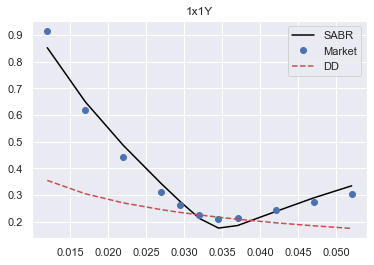

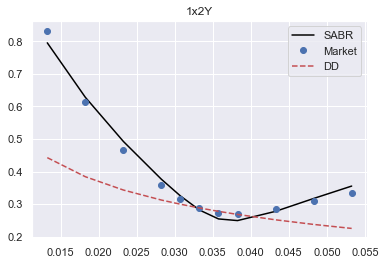

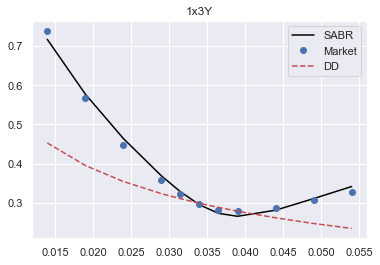

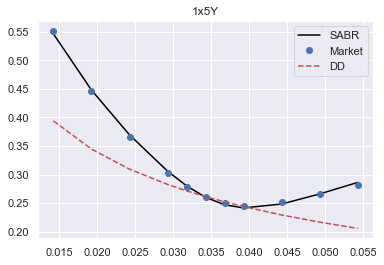

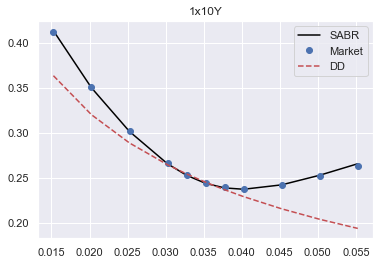

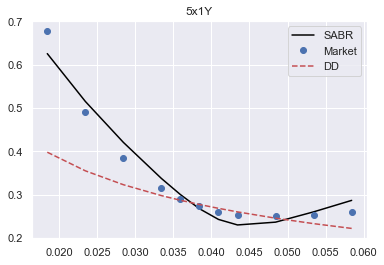

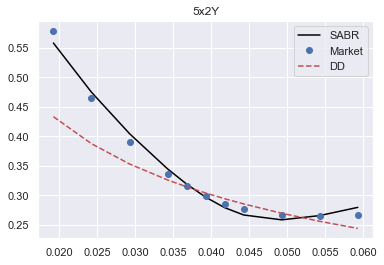

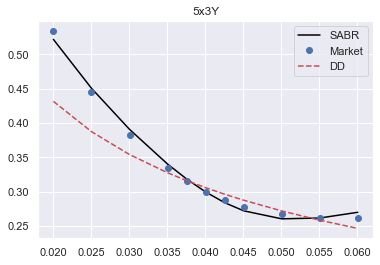

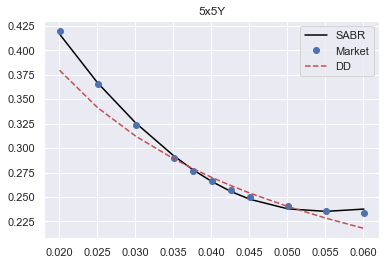

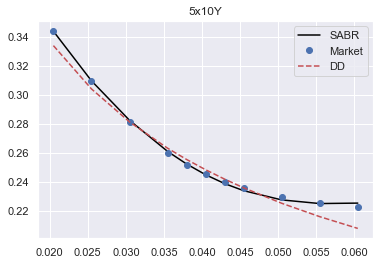

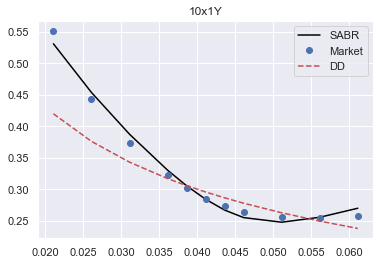

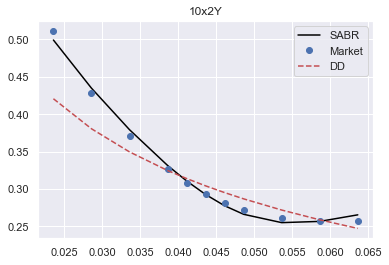

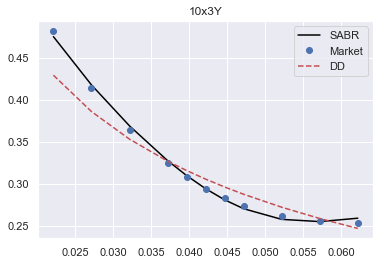

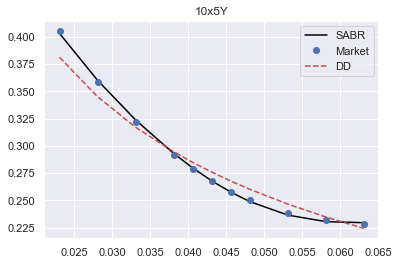

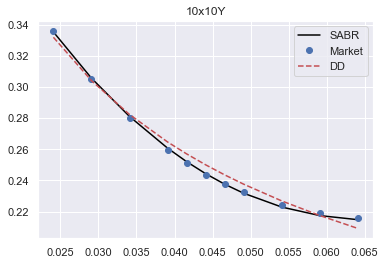

In [23]:
#plot SABR model against market vol
for row in df_SABRImpVol.index:
    for col in df_SABRImpVol.columns[2:13]:
        df_SABRImpVol.loc[row, col] = SABR(
                df_SABRImpVol.loc[row,'FSR'],
                df_Strikes.loc[row, col],
                T[row], 
                df_SABRImpVol.loc[row, 'alpha'], 
                SABRbeta,
                df_SABRImpVol.loc[row, 'rho'],
                df_SABRImpVol.loc[row, 'nu'])
    sns.set()
    plt.plot(df_Strikes.iloc[row, 2:],df_SABRImpVol.iloc[row, 2:13], c='black', label='SABR')
    plt.plot(df_Strikes.iloc[row, 2:],df_SABR.iloc[row, 2:13],'bo', label='Market')
    plt.plot(df_Strikes.iloc[row, 2:],df_DDImpVol.iloc[:,row],'r--', label="DD")
    plt.legend()
    plt.title(ExpTenor[row]+"Y")
    plt.show()

In [24]:
#Consoludate SABR implied vol to into df_SABRImpVol dataframe
df_SABRImpVol = df_SABR.copy(deep = True)
for row in df_SABRImpVol.index:
    for col in df_SABRImpVol.columns[2:13]:
        df_SABRImpVol.loc[row, col] = SABR(
                df_SABRImpVol.loc[row,'FSR'],
                df_Strikes.loc[row, col],
                T[row], 
                df_SABRImpVol.loc[row, 'alpha'], 
                SABRbeta,
                df_SABRImpVol.loc[row, 'rho'],
                df_SABRImpVol.loc[row, 'nu'])

df_SABRImpVol.to_csv('SABR_Calibs.csv',sep=',', index=False)
df_SABRImpVol

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps,FSR,alpha,rho,nu
0,1Y,1Y,0.852087,0.649236,0.485880,0.342299,0.274719,0.212342,0.176344,0.185770,0.238176,0.289289,0.334650,0.032007,0.139074,-0.633223,2.049416
1,1Y,2Y,0.795537,0.628212,0.492553,0.376296,0.325059,0.281831,0.254500,0.249421,0.277816,0.317318,0.355446,0.033259,0.184632,-0.525128,1.677575
2,1Y,3Y,0.717232,0.577418,0.464132,0.368883,0.328331,0.295071,0.273222,0.265716,0.281279,0.310839,0.341685,0.034011,0.196838,-0.482828,1.438245
3,1Y,5Y,0.546443,0.448024,0.369531,0.305966,0.280299,0.260145,0.247028,0.241615,0.248444,0.266116,0.286315,0.034261,0.178072,-0.407774,1.027670
4,1Y,10Y,0.413120,0.349923,0.301478,0.265718,0.252980,0.244053,0.239006,0.237514,0.242405,0.253058,0.265800,0.035255,0.169544,-0.233982,0.714936
5,5Y,1Y,0.625158,0.514840,0.420303,0.337011,0.299759,0.267131,0.242456,0.229717,0.236185,0.259932,0.286423,0.038427,0.167106,-0.581929,1.311456
6,5Y,2Y,0.557947,0.474736,0.404579,0.344917,0.319243,0.297056,0.279283,0.266871,0.258623,0.265842,0.279744,0.039273,0.200131,-0.544789,1.039860
7,5Y,3Y,0.521684,0.450476,0.390605,0.340039,0.318337,0.299424,0.283794,0.271949,0.260235,0.261427,0.269772,0.040074,0.210344,-0.549808,0.936838
8,5Y,5Y,0.416537,0.366687,0.325735,0.292163,0.278082,0.265904,0.255746,0.247701,0.237906,0.235325,0.237683,0.040070,0.190253,-0.504292,0.654840
9,5Y,10Y,0.343835,0.309594,0.282335,0.260870,0.252155,0.244746,0.238616,0.233722,0.227355,0.224832,0.225144,0.040484,0.174979,-0.414091,0.465994


[Back to top](#content)

<a id="Question3"></a>
### 3. Price the following swaptions using the calibrated `Displaced-Diffusion` and `SABR` model.

- payer 2y x 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%
- receiver 8y x 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

In [25]:
df_comb = pd.read_csv('Rates_Raw.csv')

In [26]:
def Libor_DF(D1,D2,delta = 0.5):
    L1 = (D1/D2-1)/delta
    return L1

def LiborDifInterp(tenor):
    xp = list(df_comb['Tenor'])
    yp = list(df_comb['Libor_DF'])
    return np.interp(tenor, xp, yp)

def floatLeg(expiry,tenor,delta=0.5):
    m = int(tenor/delta)
    summa = 0
    for i in range(1,m+1):
        loc = expiry + i*delta
        summa += OISDifInterp(loc)*Libor_DF(LiborDifInterp(loc-delta),LiborDifInterp(loc),delta)
    return summa*delta

#Swaption calculator based on Tenor and Expiry
def Swaption(expiry, tenor):
    return floatLeg(expiry,tenor)/PVBP(expiry,tenor)

#Interpolation function using Cubic Splined Method
def ParameterInterp (expiry, tenor, data):
    splied_from_expiry = []
    for i in [1,2,3,5,10]:
        result = CubicSpline([1, 5, 10], data[i], bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
        splied_from_expiry.append(result)

    extract = []
    for i in range(5):
        extract.append(splied_from_expiry[i](expiry))

    result = CubicSpline([1,2,3,5,10], extract, bc_type=((2, 0.0), (2, 0.0)), extrapolate=True)
    return float(result(tenor))

def Displaced_Diffusion(F, K, T, sigma, beta, opt):
    return Black76Lognormal(F/beta, K+(1-beta)/beta*F, T,sigma*beta, opt)

In [27]:
new_K=np.arange(0.01,0.09,0.01)
Table_Swaptions=pd.DataFrame(index=['Pay 2yx10y DD','Pay 2yx10y SABR','Rec 8yx10y DD','Rec 8yx10y SABR'],columns=new_K)

`payer` 2y x 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

In [28]:
sigma_Pay = ParameterInterp(2,10,df_sigma)
beta_Pay  = ParameterInterp(2,10,df_beta)
alpha_Pay = ParameterInterp(2,10,df_alpha)
rho_Pay   = ParameterInterp(2,10,df_rho)
nu_Pay    = ParameterInterp(2,10,df_nu)

F_Pay = Swaption(2,10)
T2_10=[2,10]
for k in new_K:
    PricePayDD   = Displaced_Diffusion(F_Pay,k,T2_10,sigma_Pay,beta_Pay,'Call') 
    PricePaySABR = Black76Lognormal(F_Pay,k, T2_10, SABR(F_Pay, k, T2_10, alpha_Pay, 0.9, rho_Pay, nu_Pay), 'Call')
    Table_Swaptions.loc['Pay 2yx10y DD',k]=PricePayDD
    Table_Swaptions.loc['Pay 2yx10y SABR',k]=PricePaySABR

`receiver` 8y x 10y K = 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

In [29]:
# receiver 8y * 10y
sigma_Rec = ParameterInterp(8,10,df_sigma)
beta_Rec  = ParameterInterp(8,10,df_beta)
alpha_Rec = ParameterInterp(8,10,df_alpha)
rho_Rec   = ParameterInterp(8,10,df_rho)
nu_Rec    = ParameterInterp(8,10,df_nu)

F_REC = Swaption(8,10)
T8_10=[8,10]
for k in new_K:
    PriceRecDD   = Displaced_Diffusion(F_REC,k,T8_10,sigma_Rec,beta_Rec,'Put')
    PriceRecSABR = Black76Lognormal(F_REC, k, T8_10, SABR(F_REC,k, T8_10, alpha_Rec, 0.9, rho_Rec, nu_Rec), 'Put')
    Table_Swaptions.loc['Rec 8yx10y DD',k]=PriceRecDD
    Table_Swaptions.loc['Rec 8yx10y SABR',k]=PriceRecSABR

`Generating Result`

In [30]:
Table_Swaptions.to_csv('Table_Swaptions.csv',sep=',')
Table_Swaptions

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08
Pay 2yx10y DD,0.28824,0.194902,0.112242,0.051387,0.017535,0.004246,0.000707,0.000079
Pay 2yx10y SABR,0.289057,0.196924,0.113513,0.051289,0.020762,0.009901,0.005726,0.003782
Rec 8yx10y DD,0.016236,0.031146,0.054505,0.08803,0.132618,0.188186,0.25376,0.327765
Rec 8yx10y SABR,0.013389,0.03067,0.053841,0.08536,0.128363,0.185231,0.255188,0.334542


[Back to top](#content)

### Output of Result - Swaption Calibration

`Displaced Diffusion Table`

In [31]:
df_sigmaDD = pd.DataFrame(data = np.array(df_vol.ATM).reshape(3,5),
                        index = ["1Y","5Y","10Y"], 
                        columns = ["1Y", "2Y", "3Y", "5Y", "10Y"])

df_betaDD = pd.DataFrame(data = np.array(df_vol['β']).reshape(3,5),
                        index = ["1Y","5Y","10Y"], 
                        columns = ["1Y", "2Y", "3Y", "5Y", "10Y"])

In [32]:
df_sigmaDD.to_csv('sigmaDD_Table.csv',sep=',')
df_betaDD.to_csv('betaDD_Table.csv',sep=',')

`SABR Table`

In [33]:
df_alphaSABR = pd.DataFrame(data = np.array(df_SABRImpVol['alpha']).reshape(3,5),
                        index = ["1Y","5Y","10Y"], 
                        columns = ["1Y", "2Y", "3Y", "5Y", "10Y"])

df_nuSABR = pd.DataFrame(data = np.array(df_SABRImpVol['nu']).reshape(3,5),
                        index = ["1Y","5Y","10Y"], 
                        columns = ["1Y", "2Y", "3Y", "5Y", "10Y"])

df_rhoSABR = pd.DataFrame(data = np.array(df_SABRImpVol['rho']).reshape(3,5),
                        index = ["1Y","5Y","10Y"], 
                        columns = ["1Y", "2Y", "3Y", "5Y", "10Y"])

In [34]:
df_alphaSABR.to_csv('alphaSABR_Table.csv',sep=',')
df_nuSABR.to_csv('nuSABR_Table.csv',sep=',')
df_rhoSABR.to_csv('rhoSABR_Table.csv',sep=',')

[Back to top](#content)